# DS 3000 HW 2
# Diego Cicotoste

Due: Tuesday Oct 8 @ 11:59 PM EST

Extra Credit Deadline: Sunday Oct 6 @ 11:59 PM EST

Earliest Possible Submission: Tuesday Sep 24

### Submission Instructions
Submit this `ipynb` file to Gradescope (this can also be done via the assignment on Canvas).  To ensure that your submitted `ipynb` file represents your latest code, make sure to give a fresh `Kernel > Restart & Run All` just before uploading the `ipynb` file to gradescope.

### Tips for success
- Start early
- Make use of Piazza (also accessible through Canvas)
- Make use of Office Hours
- Remember to use cells and headings to make the notebook easy to read (if a grader cannot find the answer to a problem, you will receive no points for it)
- Under no circumstances may one student view or share their ungraded homework or quiz with another student [(see also)](http://www.northeastern.edu/osccr/academic-integrity), though you are welcome to **talk about** (*not* show each other your answers to) the problems.

### Finally:

I designed this homework to provide **less** guidance in each subsequent part; this is on purpose, so that you slowly get used to thinking more critically about how to approach the various tasks. If you are confused as you are working, especially with the later parts, please don't hesitate to reach out for help.

# Part 1: Sunrise-Sunset API

This first part of the homework asks you to complete the pipeline which, given the lattitude / longitude and timezone of some cities:

``` python
loc_dict = {'Boston': (42.3601, -71.0589, 'US/Eastern'),
            'Lusaka': (-15.3875, 28.3228, 'Africa/Lusaka'),
            'Sydney': (-33.8688, 151.2093, 'Australia/Sydney')}
```

the keys are the `name` of the city and the values are tuples of `lat, lon, timezone_name

is able to:
- query a sunrise / sunset API
- clean and process data (timezone management & building `datetime` objects)
- For extra credit: produce the a graph of daylight through the year like this:

<img src="https://i.ibb.co/CBhWtCY/newdaylight.png" alt="newdaylight" style="width: 500px;"/>

## Part 1.1: Getting Sunrise Sunset via API (5 points)
Write the `get_sunrise_sunset()` function below so that it uses [this sunrise sunset API](https://sunrise-sunset.org/api) to produce the output (the dictionary) shown in the test case below so that it passes the case.

It may be helpful to know that this particular API...
- requires no api key
- returns about 2.5 queries per second
- did not block me when I tried to make 100 consecutive calls as quickly as possible

In [1]:
# make sure you have these modules installed
import requests
import json
import pandas as pd 

### I was getting a lot of errors so I was debugging a lot ###
sorry for the mess

In [2]:
def get_sunrise_sunset(lat, lng, date):
    """
    Fetches the sunrise and sunset times for a given latitude, longitude, and date.
    
    Args:
        lat (float): Latitude of the location.
        lng (float): Longitude of the location.
        date (str): Date for which sunrise and sunset times are needed in 'YYYY-MM-DD' format.
    
    Returns:
        dict: A dictionary containing the sunrise and sunset times in UTC, or None if there's an error.
    """
    date = pd.to_datetime(date).strftime('%Y-%m-%d')
    api_url = f"https://api.sunrise-sunset.org/json?lat={lat}&lng={lng}&date={date}"
    try:
        response = requests.get(api_url)
        if response.status_code == 200:
            try:
                data = response.json()
                if 'status' in data and data['status'] == 'OK':
                    data['lat-lng'] = (lat, lng)
                    data['date'] = date
                    return data
            except ValueError:
                print("Error: not valid JSON")
                return None
    except requests.RequestException as e:
        print(f"Request failed: {e}")
        return None


In [3]:
sun_dict = get_sunrise_sunset(lat=42.3601, lng=-71.0589, date='2022-02-15')
sun_dict_expected = \
{'results': {'sunrise': '11:38:48 AM',
            'sunset': '10:17:50 PM',
            'solar_noon': '4:58:19 PM',
            'day_length': '10:39:02',
            'civil_twilight_begin': '11:11:30 AM',
            'civil_twilight_end': '10:45:08 PM',
            'nautical_twilight_begin': '10:38:37 AM',
            'nautical_twilight_end': '11:18:00 PM',
            'astronomical_twilight_begin': '10:06:05 AM',
            'astronomical_twilight_end': '11:50:33 PM'},
 'status': 'OK',
 'tzid': 'UTC',
 'lat-lng': (42.3601, -71.0589),
 'date': '2022-02-15'}

assert sun_dict == sun_dict_expected, 'get_sunrise_sunset() error'

## Part 1.2 Timezone Considerations: (5 points)

It may appear the test case above works, but a look at the API's documentation reminds us: 

    "NOTE: All times are in UTC and summer time adjustments are not included in the returned data."
    
Meaning that we would need to change the timezone ourself if comparing different locations. 

Complete the `change_tz()` below so that it passes the given test case. 

In [4]:
import pytz
from datetime import datetime

In [5]:
# I have started the function for you
def change_tz(dt, timezone_from, timezone_to):
    """ converts timezone of a timezone naive datetime object
    
    Args:
        dt (datetime): datetime (or time) object without timezone
        timezone_from (str): timezone of input
        timezone_to (str): timezone of output datetime
        
    Returns:
        dt_to (datetime): datetime object corresponding to 
            unix_time
    """
    dt_from = pytz.timezone(timezone_from).localize(dt)  
    dt_to = dt_from.astimezone(pytz.timezone(timezone_to))  
    return dt_to


In [6]:
# build test case input / output
dt_no_tz = datetime(2021, 2, 13, 9, 54, 4, 270088)
dt_expect = datetime(2021, 2, 13, 14, 54, 4, 270088, tzinfo=pytz.timezone('GMT'))

# compute actual output
dt = change_tz(dt_no_tz, timezone_from='US/Eastern', timezone_to='GMT')

assert dt == dt_expect, 'change_tz() error'

In [7]:
# build test case input / output
dt_no_tz = datetime(2021, 2, 13, 9, 54, 4, 270088)
dt_expect = datetime(2021, 2, 13, 9, 54, 4, 270088, tzinfo=pytz.timezone('GMT'))

# compute actual output
dt = change_tz(dt_no_tz, timezone_from='GMT', timezone_to='GMT')

assert dt == dt_expect, 'change_tz() error'

## Part 1.3: Turning the dictionary into a Series (5 points)
Build `clean_sun_dict()` to pass each of the two test cases below.  Note that:
- sunrise and sunset are `time` objects which account for daylight's saving:
    - include the date when building these objects
    - use `change_tz()` above to cast them to the proper timezone
    - build `time` objects by calling `datetime.time()` to discard the date of a `datetime`
    - importing `pandas as pd` and using `pd.to_datetime` may also be helpful
- `sunrise_hr` and `sunset_hr` are the hours since the day began in local timezone (more easily graphed)
    - you may use `.strftime()` and `int()` to cast time objects to strings and then integers (which may be helpful) 
    
**NOTE:** There may be more than one way to accomplish writing this function; as long as the function passes both `assert` test cases, you may continue. Just do be sure to comment and present your code as cleanly as possible. **NOTE ALSO** that because of the way *I* made the solution, the `sunrise_hr` and `sunset_hr` values are rounded strangely. If you are getting something *close*, you **may** change the test case to match your so that the `assert` works.

In [8]:
from datetime import datetime, time
import pandas as pd

In [9]:
def clean_sun_dict(sun_dict, timezone_to):
    """
    Builds a pandas Series and cleans the output of the API.

    Args:
        sun_dict (dict): Dictionary of JSON data from the API.
        timezone_to (str): Target timezone for the output times (API returns UTC times).

    Returns:
        pd.Series: All times converted to time objects in the specified timezone.
    """

    date_str = sun_dict['date']
    lat_lng = sun_dict['lat-lng']
    date = pd.to_datetime(date_str)

    sunrise_utc = pd.to_datetime(f"{date_str} {sun_dict['results']['sunrise']}")
    sunset_utc = pd.to_datetime(f"{date_str} {sun_dict['results']['sunset']}")
    sunrise_local = change_tz(sunrise_utc, 'UTC', timezone_to)
    sunset_local = change_tz(sunset_utc, 'UTC', timezone_to)

    sunrise_time = sunrise_local.time()
    sunset_time = sunset_local.time()
    sunrise_hr = sunrise_local.hour + sunrise_local.minute / 60 + sunrise_local.second / 3600
    sunset_hr = sunset_local.hour + sunset_local.minute / 60 + sunset_local.second / 3600

    sun_series = pd.Series({
        'date': date,
        'lat-lng': lat_lng,
        'sunrise': sunrise_time,
        'sunrise_hr': round(sunrise_hr, 16),
        'sunset': sunset_time,
        'sunset_hr': round(sunset_hr, 16)
    })

    return sun_series

In [10]:
sun_dict = {'results': {'sunrise': '11:38:48 AM',
                        'sunset': '10:17:50 PM',
                        'solar_noon': '4:58:19 PM',
                        'day_length': '10:39:02',
                        'civil_twilight_begin': '11:11:30 AM',
                        'civil_twilight_end': '10:45:08 PM',
                        'nautical_twilight_begin': '10:38:37 AM',
                        'nautical_twilight_end': '11:18:00 PM',
                        'astronomical_twilight_begin': '10:06:05 AM',
                        'astronomical_twilight_end': '11:50:33 PM'},
             'status': 'OK',
             'lat-lng': (42.3601, -71.0589),
             'date': '2022-02-15'}

# test without timezone conversion
sun_series = clean_sun_dict(sun_dict, timezone_to='GMT')

sun_series_exp = pd.Series(
{'date': datetime(year=2022, month=2, day=15),
'lat-lng': (42.3601, -71.0589),
'sunrise': time(hour=11, minute=38, second=48),
'sunrise_hr': 11.646666666666667,
'sunset': time(hour=22, minute=17, second=50),
'sunset_hr': 22.297222222222224})

assert sun_series.eq(sun_series_exp).all(), 'clean_sun_dict() error (GMT)'

In [11]:
# test with timezone conversion
sun_series = clean_sun_dict(sun_dict, timezone_to='US/Eastern',)

sun_series_exp = pd.Series(
{'date': datetime(year=2022, month=2, day=15),
'lat-lng': (42.3601, -71.0589),
'sunrise': time(hour=6, minute=38, second=48),
'sunrise_hr': 6.6466666666666665,
'sunset': time(hour=17, minute=17, second=50),
'sunset_hr': 17.297222222222224})

assert sun_series.eq(sun_series_exp).all(), 'clean_sun_dict() error (EST)'

## Part 1.4: Getting our Data Frame (5 points)

Write the `get_annual_sun_data()` function so that it produces the outputs shown below.  This function should make use of:
 - `get_sunrise_sunset()`
 - `clean_sun_dict()`
   
as built above. I will start the function for you to help!

The following snippet:

```python
loc_dict = {'Boston': (42.3601, -71.0589, 'US/Eastern'),
            'Lusaka': (-15.3875, 28.3228, 'Africa/Lusaka'),
            'Sydney': (-33.8688, 151.2093, 'Australia/Sydney')}
df_annual_sun = get_annual_sun_data(loc_dict, year=2021, period_day=30)
df_annual_sun.head(6)
```

should generate:

|    |   city |       date |              lat-lng |  sunrise | sunrise_hr |   sunset | sunset_hr |
|---:|-------:|-----------:|---------------------:|---------:|-----------:|---------:|----------:|
|  0 | Boston | 2021-01-01 |  (42.3601, -71.0589) | 07:11:49 |   7.196944 | 16:24:12 | 16.403333 |
|  1 | Lusaka | 2021-01-01 |  (-15.3875, 28.3228) | 05:38:33 |   5.642500 | 18:42:09 | 18.702500 |
|  2 | Sydney | 2021-01-01 | (-33.8688, 151.2093) | 05:46:24 |   5.773333 | 20:10:53 | 20.181389 |
|  3 | Boston | 2021-01-31 |  (42.3601, -71.0589) | 06:56:43 |   6.945278 | 16:58:42 | 16.978333 |
|  4 | Lusaka | 2021-01-31 |  (-15.3875, 28.3228) | 05:55:43 |   5.928611 | 18:44:35 | 18.743056 |
|  5 | Sydney | 2021-01-31 | (-33.8688, 151.2093) | 06:14:24 |   6.240000 | 20:02:42 | 20.045000 |

In [12]:
# could be useful
from datetime import timedelta

In [13]:
def get_annual_sun_data(loc_dict, year=2021, period_day=30): 
    """Pulls evenly spaced sunrise/sunsets from API over a year per city.
    
    Args:
        loc_dict (dict): keys are cities, values are tuples of 
            (lat, lon, tz_str) where tz_str is a timezone
            string included in pytz.all_timezones.
        year (int): year to query.
        period_day (int): how many days between data queries.
            (i.e., period_day=1 will get data for every day of the year).
            
    Returns:
        df_annual_sun (DataFrame): each row represents a 
            sunrise/sunset datapoint, see get_sunrise_sunset().
    """

    cycle_day = pd.to_datetime(f'{year}-01-01')
    cycle_city = loc_dict.keys()
    sun_data_list = [] 
    
    while cycle_day.year == year:
        for city in cycle_city:
            city_series = {'city': city}
            data_info = get_sunrise_sunset(loc_dict[city][0], loc_dict[city][1], cycle_day)
            
            if data_info is not None:
                clean_data = clean_sun_dict(data_info, loc_dict[city][2])
                city_series["date"] = pd.Timestamp(cycle_day.year, cycle_day.month, cycle_day.day)
                city_series["lat-lng"] = f"({loc_dict[city][0]}, {loc_dict[city][1]})"
                city_series["sunrise"] = clean_data["sunrise"]
                city_series["sunrise_hr"] = clean_data["sunrise_hr"]
                city_series["sunset"] = clean_data["sunset"]
                city_series["sunset_hr"] = clean_data["sunset_hr"]

                sun_data_list.append(city_series)

        cycle_day += pd.DateOffset(days=period_day)
    
    df_annual_sun = pd.DataFrame(sun_data_list)
    
    return df_annual_sun


In [14]:
loc_dict = {'Boston': (42.3601, -71.0589, 'US/Eastern'),
            'Lusaka': (-15.3875, 28.3228, 'Africa/Lusaka'),
            'Sydney': (-33.8688, 151.2093, 'Australia/Sydney')}

# you may find that setting period_day to a larger value is quicker for debug
# period_day=5 takes about a minute or so given the API does 2-3 requests / sec
df_annual_sun = get_annual_sun_data(loc_dict, year=2021, period_day=30)

In [15]:
df_annual_sun.head(6)

,city,date,lat-lng,sunrise,sunrise_hr,sunset,sunset_hr
0,Boston,2021-01-01,"(42.3601, -71.0589)",07:11:49,7.196944,16:24:12,16.403333
1,Lusaka,2021-01-01,"(-15.3875, 28.3228)",05:38:33,5.642500,18:42:09,18.702500
2,Sydney,2021-01-01,"(-33.8688, 151.2093)",05:46:24,5.773333,20:10:53,20.181389
3,Boston,2021-01-31,"(42.3601, -71.0589)",06:56:43,6.945278,16:58:42,16.978333
4,Lusaka,2021-01-31,"(-15.3875, 28.3228)",05:55:43,5.928611,18:44:35,18.743056
5,Sydney,2021-01-31,"(-33.8688, 151.2093)",06:14:24,6.240000,20:02:42,20.045000


## Part 1.5: Plotting the data (5 points)

Using [plt.fillbetween()](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.fill_between.html), like [this example](https://colab.research.google.com/drive/1eYuuwGwQKEa6x84fqpdVlf46sXLDmhCZ?usp=sharing), write the `plot_daylight()` function so that:

``` python
plot_daylight(df_annual_sun)
```

produces a similar graph to:

<img src="https://i.ibb.co/CBhWtCY/newdaylight.png" alt="newdaylight" style="width: 500px;"/>

Be sure that your graph displays in Jupyter notebook (no need to save it in another form).

In [16]:
# modules you might use
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
sns.set(font_scale=1.2)

def plot_daylight(df_annual_sun):
    """Produces a plot of daylight seen across cities.
    
    Args:
        df_annual_sun (DataFrame): each row represents a 
            sunrise / sunset datapoint, see get_sunrise_sunset()
    """
    
    df_annual_sun['sunrise_datetime'] = pd.to_datetime(df_annual_sun['date'].astype(str) + ' ' + df_annual_sun['sunrise'].astype(str))
    df_annual_sun['sunset_datetime'] = pd.to_datetime(df_annual_sun['date'].astype(str) + ' ' + df_annual_sun['sunset'].astype(str))
    
    df_annual_sun['daylight_hours'] = (df_annual_sun['sunset_datetime'] - df_annual_sun['sunrise_datetime']).dt.total_seconds() / 3600
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_annual_sun, x='date', y='daylight_hours', hue='city', marker='o')
    
    plt.title('Daylight Duration Across Cities Over Time')
    plt.xlabel('Date')
    plt.ylabel('Daylight Hours')
    
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

In [18]:
# takes about a minute to run with period_day=7, worth the wait to characterize
# the sudden jumps due to daylight savings times
df_annual_sun = get_annual_sun_data(loc_dict, year=2021, period_day=7)

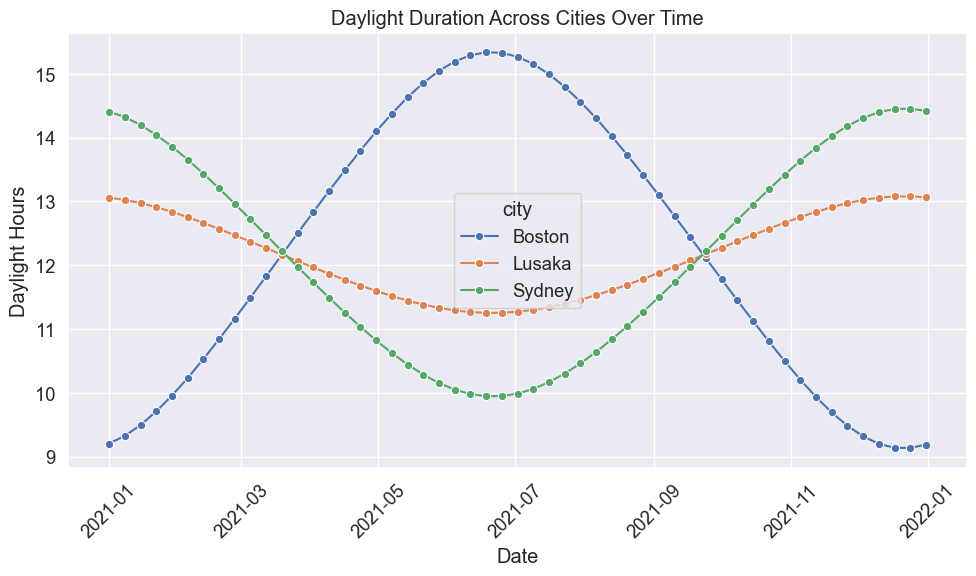

In [19]:
plot_daylight(df_annual_sun)

# Part 2: Spotify API (Spotipy)

**Note**: The following is copied verbatim from the end of Day2_APIs on Canvas.

The Spotify API is quite powerful and gives us access to any song/artist in its libraries, plus even more information that you might not have thought of. There is also a module that has been created to access the API within python. Open up a terminal (or do it in jupyter notebook; this is a magic module) and run:

`pip install spotipy`

In [20]:
# after installation
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

Just like with OpenWeather, we need to make an account [here](https://developer.spotify.com/) (this is essentially the same as making a regular Spotify account) and then get an API key (Spotify requires two things, actually, a Client ID and a secret key). At the above website, go to:

- Dashboard
- Log into your Spotify account (make one if you don't have one)
- Accept the terms of using the API
- Create an app (you can call it anything, I called mine `DS3000_Spotify`)
- Enter `http://localhost/` when it prompts you for a Redirect URI
- Get a client ID (mine is `592acf2d2dc84d94bbc652f2f1d72375`, though it is usually good practice to **not** share this) and a client secret (**never share this with anyone**: save it in a separate file like we did with our OpenWeather API key earlier)

There exists a file `spotify_secret.py` in same directory as this jupyter notebook which contains:
    
    secret = 'professorgerberssecretspotify'

**Put your own secret in the `secret = ` and save your file as `spotify_secret.py` in the same directory as this notebook.

In [21]:
# make sure you have named your file spotify_secret.py
from spotify_secret import secret

In [22]:
# Authentication
# Make sure you use your OWN client ID (DO NOT leave mine in there!!)
cid = 'd6972d59ff754918a12b2b6adc9f8821'

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

## Part 2.1: Uniform Resource Identifiers (URI) (5 points)

An important component of using the Spotify API is the use of the uniform resource identifiers, pointing at each object in the API. We need a URI to perform any function with the API referring to an object in Spotify. The URI of any Spotify object is contained in its shareable link. For example, the link to the Global top songs playlist, when found from the Spotify desktop application, is:

In [23]:
# if you receive a couldn't read cache or write token error, it should simply be a warning and not be a problem
playlist_link = "https://open.spotify.com/playlist/37i9dQZF1DXcBWIGoYBM5M"
playlist_URI = playlist_link.split("/")[-1].split("?")[0]
track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]

In [24]:
# take a look at a single track from the playlist
# it is commented out because it will produce a lot of output! You can uncomment it out to see what it looks like.

sp.playlist_tracks(playlist_URI)["items"][0]

{'added_at': '2024-04-19T04:01:02Z',
 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'},
  'href': 'https://api.spotify.com/v1/users/',
  'id': '',
  'type': 'user',
  'uri': 'spotify:user:'},
 'is_local': False,
 'primary_color': None,
 'track': {'preview_url': None,
  'available_markets': ['AR',
   'AU',
   'AT',
   'BE',
   'BO',
   'BR',
   'BG',
   'CA',
   'CL',
   'CO',
   'CR',
   'CY',
   'CZ',
   'DK',
   'DO',
   'DE',
   'EC',
   'EE',
   'SV',
   'FI',
   'FR',
   'GR',
   'GT',
   'HN',
   'HK',
   'HU',
   'IS',
   'IE',
   'IT',
   'LV',
   'LT',
   'LU',
   'MY',
   'MT',
   'MX',
   'NL',
   'NZ',
   'NI',
   'NO',
   'PA',
   'PY',
   'PE',
   'PH',
   'PL',
   'PT',
   'SG',
   'SK',
   'ES',
   'SE',
   'CH',
   'TW',
   'TR',
   'UY',
   'US',
   'GB',
   'AD',
   'LI',
   'MC',
   'ID',
   'JP',
   'TH',
   'VN',
   'RO',
   'IL',
   'ZA',
   'SA',
   'AE',
   'BH',
   'QA',
   'OM',
   'KW',
   'EG',
   'MA',
   'DZ',
   'TN',
   'LB',


On the Getting to Know You form, I asked what your favorite song was. Below is the url for the Spotify playlist created from those songs. Read it into python the way we did the above playlist.

`playlist_link = "https://open.spotify.com/playlist/3lDbfa8bVjjcpJtFIoHBv2?si=bc1a57aa591742cd"`

In [25]:
playlist_link = "https://open.spotify.com/playlist/3lDbfa8bVjjcpJtFIoHBv2?si=bc1a57aa591742cd"
playlist_URI = playlist_link.split("/")[-1].split("?")[0]
track = [x["track"] for x in sp.playlist_tracks(playlist_URI)["items"]]

sp.playlist_tracks(playlist_URI)["items"][0]

{'added_at': '2024-09-14T20:08:58Z',
 'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/31sxnmkyhykidsng56d6se22p67a'},
  'href': 'https://api.spotify.com/v1/users/31sxnmkyhykidsng56d6se22p67a',
  'id': '31sxnmkyhykidsng56d6se22p67a',
  'type': 'user',
  'uri': 'spotify:user:31sxnmkyhykidsng56d6se22p67a'},
 'is_local': False,
 'primary_color': None,
 'track': {'preview_url': 'https://p.scdn.co/mp3-preview/37beb1785c5a3f9fa734af22d64571d42449fe22?cid=d6972d59ff754918a12b2b6adc9f8821',
  'available_markets': ['AR',
   'AU',
   'AT',
   'BE',
   'BO',
   'BR',
   'BG',
   'CA',
   'CL',
   'CO',
   'CR',
   'CY',
   'CZ',
   'DK',
   'DO',
   'DE',
   'EC',
   'EE',
   'SV',
   'FI',
   'FR',
   'GR',
   'GT',
   'HN',
   'HK',
   'HU',
   'IS',
   'IE',
   'IT',
   'LV',
   'LT',
   'LU',
   'MY',
   'MT',
   'MX',
   'NL',
   'NZ',
   'NI',
   'NO',
   'PA',
   'PY',
   'PE',
   'PH',
   'PL',
   'PT',
   'SG',
   'SK',
   'ES',
   'SE',
   'CH',
   'TW',
   'TR',

In [26]:
# note that you may only get the first 100 songs
# check out the spotipy documentation if you want to try to get the full playlist, though the first 100 is perfectly fine for this HW
len(track_uris)

50

## Part 2.2: Build a dictionary of track info (5 points)

I have initialized the `playlist_dict` dictionary for you below, complete with keys and empty lists. Use a for loop to loop through the tracks in our class's playlist and `.append()` the associated values for each track to each of the lists, building out the dictionary. You may write a function to do this, but you don't have to (I didn't). **Note**: if you know of a faster way to do this than with a for loop, you are welcome to use it.

In [27]:
playlist_dict = {'track_uri': list(),
                'track_name': list(),
                'artist_uri': list(),
                'artist_name': list(),
                'artist_pop': list(),
                'artist_genres': list(),
                'album': list(),
                'track_pop': list()}

In [28]:
for items in track:
    playlist_dict["track_uri"].append(items["uri"])
    playlist_dict["track_name"].append(items["name"])
    playlist_dict["artist_uri"].append(items["artists"][0]["uri"])
    playlist_dict["artist_name"].append(items["artists"][0]["name"])
    artist_data = sp.artist(items["artists"][0]["uri"])
    playlist_dict["artist_pop"].append(artist_data["popularity"])
    playlist_dict["artist_genres"].append(artist_data["genres"])
    playlist_dict["album"].append(items["album"]["name"])
    playlist_dict["track_pop"].append(items["popularity"])

print(playlist_dict)

{'track_uri': ['spotify:track:2dshtwEGNpyrE0x69wUiHj', 'spotify:track:4JehYebiI9JE8sR8MisGVb', 'spotify:track:42sqQTi2EqDPd6Iex66joE', 'spotify:track:5CQ30WqJwcep0pYcV4AMNc', 'spotify:track:2GDnUFJ1ZwP3ooFqQHY1ht', 'spotify:track:6wOYnPq1hPihRepcDClPUw', 'spotify:track:3cgf3PmzUZKLCRulrKrzZG', 'spotify:track:65yNr1EO2TOBEYCz45tuOf', 'spotify:track:4boJYAy3ZQmCHp6xIKDJIx', 'spotify:track:5iJKGpnFfvbjZJeAtwXfCj', 'spotify:track:3JvrhDOgAt6p7K8mDyZwRd', 'spotify:track:4lpvCG7eNzHAXwvMxWUNjz', 'spotify:track:6C2nVSSeXNqfoY8t6tliZ4', 'spotify:track:2dUqYl3tz9uUVlr4oaVmIT', 'spotify:track:19a3JfW8BQwqHWUMbcqSx8', 'spotify:track:1ONWW6AtqqwjhMdQ74n2fM', 'spotify:track:2dBwB667LHQkLhdYlwLUZK', 'spotify:track:5ekfEEnkAHxrn2KNvyZg7E', 'spotify:track:02wk5BttM0QL38ERjLPQJB', 'spotify:track:22TntnVO3lQNDR5nsvxGRs', 'spotify:track:2plbrEY59IikOBgBGLjaoe', 'spotify:track:6BrfgV35h3NfTtIdMqhmFQ', 'spotify:track:4QhWbupniDd44EDtnh2bFJ', 'spotify:track:0OlS52TmtK2gPaEtdmr7DN', 'spotify:track:561pBFcFL2

In [29]:
len(playlist_dict['track_uri'])

100

## Part 2.3: Extracting Features from Tracks (5 points)

Now that we have a list of track URIs, we can extract features from these tracks. Spotify has a list of these features for each of its tracks, from analysis of the audio. We can access these with a single method of the spotify object `audio_features(uri)`. This gives us a list of mostly numerical features that we can use for analysis.

In [30]:
# note that .audio_features returns a dictionary in a list of 1
sp.audio_features(playlist_dict['track_uri'][0])

[{'danceability': 0.671,
  'energy': 0.543,
  'key': 7,
  'loudness': -5.45,
  'mode': 0,
  'speechiness': 0.0357,
  'acousticness': 0.376,
  'instrumentalness': 0.000209,
  'liveness': 0.11,
  'valence': 0.112,
  'tempo': 124.051,
  'type': 'audio_features',
  'id': '2dshtwEGNpyrE0x69wUiHj',
  'uri': 'spotify:track:2dshtwEGNpyrE0x69wUiHj',
  'track_href': 'https://api.spotify.com/v1/tracks/2dshtwEGNpyrE0x69wUiHj',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/2dshtwEGNpyrE0x69wUiHj',
  'duration_ms': 170453,
  'time_signature': 4}]

I have initiated an empty `song_dict` for you below. Loop through the track URIs of our `playlist_dict` from the previous part then for each song, loop through the audio features and add corresponding key-value pairs to the dictionary. Finally, after you have created the dictionary, cast it to a Data Frame called `song_df` using pandas. **Note**: if you know of a faster way to do this than with a nested for loop, you are welcome to use it.

In [36]:
from collections import defaultdict
import pandas as pd

song_dict = defaultdict(list)

In [37]:
for track_uri in playlist_dict['track_uri']:
    audio_features = sp.audio_features(track_uri)[0]
    for key, value in audio_features.items():
        song_dict[key].append(value)

song_df = pd.DataFrame(song_dict)

In [38]:
# uncomment the below to see if you completed your task
song_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.671,0.543,7,-5.450,0,0.0357,0.37600,0.000209,0.1100,0.112,124.051,audio_features,2dshtwEGNpyrE0x69wUiHj,spotify:track:2dshtwEGNpyrE0x69wUiHj,https://api.spotify.com/v1/tracks/2dshtwEGNpyr...,https://api.spotify.com/v1/audio-analysis/2dsh...,170453,4
1,0.508,0.720,11,-5.908,0,0.0628,0.27200,0.000000,0.0563,0.472,79.983,audio_features,4JehYebiI9JE8sR8MisGVb,spotify:track:4JehYebiI9JE8sR8MisGVb,https://api.spotify.com/v1/tracks/4JehYebiI9JE...,https://api.spotify.com/v1/audio-analysis/4Jeh...,261640,4
2,0.765,0.796,9,-3.476,1,0.0356,0.03530,0.000000,0.6980,0.492,107.966,audio_features,42sqQTi2EqDPd6Iex66joE,spotify:track:42sqQTi2EqDPd6Iex66joE,https://api.spotify.com/v1/tracks/42sqQTi2EqDP...,https://api.spotify.com/v1/audio-analysis/42sq...,190903,4
3,0.338,0.340,9,-12.049,0,0.0339,0.58000,0.003200,0.1160,0.197,82.433,audio_features,5CQ30WqJwcep0pYcV4AMNc,spotify:track:5CQ30WqJwcep0pYcV4AMNc,https://api.spotify.com/v1/tracks/5CQ30WqJwcep...,https://api.spotify.com/v1/audio-analysis/5CQ3...,482830,4
4,0.665,0.655,2,-6.335,1,0.0535,0.00266,0.000000,0.2980,0.626,124.028,audio_features,2GDnUFJ1ZwP3ooFqQHY1ht,spotify:track:2GDnUFJ1ZwP3ooFqQHY1ht,https://api.spotify.com/v1/tracks/2GDnUFJ1ZwP3...,https://api.spotify.com/v1/audio-analysis/2GDn...,128512,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.658,0.282,2,-8.282,0,0.0353,0.43300,0.000000,0.0741,0.390,119.757,audio_features,1cQ3LIkZE68pMSnPhZWXLu,spotify:track:1cQ3LIkZE68pMSnPhZWXLu,https://api.spotify.com/v1/tracks/1cQ3LIkZE68p...,https://api.spotify.com/v1/audio-analysis/1cQ3...,277724,3
96,0.610,0.682,7,-4.877,1,0.1230,0.31800,0.000000,0.3210,0.694,142.966,audio_features,57L5EYzCfHS7Jd58rV33lW,spotify:track:57L5EYzCfHS7Jd58rV33lW,https://api.spotify.com/v1/tracks/57L5EYzCfHS7...,https://api.spotify.com/v1/audio-analysis/57L5...,190075,4
97,0.613,0.146,2,-11.211,1,0.0394,0.95400,0.000000,0.0857,0.413,117.075,audio_features,59ufJBDa8L0dduJwcxXnZj,spotify:track:59ufJBDa8L0dduJwcxXnZj,https://api.spotify.com/v1/tracks/59ufJBDa8L0d...,https://api.spotify.com/v1/audio-analysis/59uf...,210827,4
98,0.851,0.652,8,-4.333,1,0.0367,0.03170,0.000000,0.0936,0.696,119.944,audio_features,07oO1U722crtVcavi6frX6,spotify:track:07oO1U722crtVcavi6frX6,https://api.spotify.com/v1/tracks/07oO1U722crt...,https://api.spotify.com/v1/audio-analysis/07oO...,190782,4


## Part 2.4: Cleaning/manipulating (5 points)

Look at the information in `playlist_dict` and the information in `song_df`. What information would you like to add to `song_df` from `playlist_dict`? What information is in `song_df` that is not very useful?

**Briefly discuss** your answers to those two questions in a markdown cell, then make the changes to `song_df`. That is: add the columns to the Data Frame that you wish to add, and delete the columns that are not useful. Keep in mind that there are many "correct" answers here.

I believe the type, id, uri, analysis_url, and track_href isn't very helpful and could be removed mainly because it isn't information someone needs unless they are an developer, danceability is cool to have, and the others I believe it would be more beneficial for people who understands music better

What I would add in the song_df would be the track name, artist name, and the track popularity as well, just to have more information about the music

In [41]:

song_df['track_name'] = playlist_dict['track_name']
song_df['artist_name'] = playlist_dict['artist_name']
song_df['track_pop'] = playlist_dict['track_pop']

song_df.pop('type')
song_df.pop("id")
song_df.pop("uri")
song_df.pop("analysis_url")
song_df.pop("track_href")

song_df


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_name,artist_name,track_pop
0,0.671,0.543,7,-5.450,0,0.0357,0.37600,0.000209,0.1100,0.112,124.051,170453,4,DEEP IN THE WATER,Don Toliver,60
1,0.508,0.720,11,-5.908,0,0.0628,0.27200,0.000000,0.0563,0.472,79.983,261640,4,Halo,Beyoncé,72
2,0.765,0.796,9,-3.476,1,0.0356,0.03530,0.000000,0.6980,0.492,107.966,190903,4,OBVIOUS,Fordo,62
3,0.338,0.340,9,-12.049,0,0.0339,0.58000,0.003200,0.1160,0.197,82.433,482830,4,Stairway to Heaven - Remaster,Led Zeppelin,77
4,0.665,0.655,2,-6.335,1,0.0535,0.00266,0.000000,0.2980,0.626,124.028,128512,4,ocd,ericdoa,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.658,0.282,2,-8.282,0,0.0353,0.43300,0.000000,0.0741,0.390,119.757,277724,3,Earned It (Fifty Shades Of Grey),The Weeknd,75
96,0.610,0.682,7,-4.877,1,0.1230,0.31800,0.000000,0.3210,0.694,142.966,190075,4,HIGHJACK,A$AP Rocky,75
97,0.613,0.146,2,-11.211,1,0.0394,0.95400,0.000000,0.0857,0.413,117.075,210827,4,Dreamer,Laufey,57
98,0.851,0.652,8,-4.333,1,0.0367,0.03170,0.000000,0.0936,0.696,119.944,190782,4,"Double Life - From ""Despicable Me 4""",Pharrell Williams,82


## Part 2.5: Plotting (5 points)

Using plotly, make two plots (in separate code cells):
- of energy (x-axis) versus danceability (y-axis) that has the song title as hover data.
- of acousticness (x-axis) versus loudness (y-axis) that has the song title as hover data.

**Then**, in a markdown cell, discuss the relationships (if any) you see in these plots and whether those relationships make sense to you/what you would have expected to see.

In [42]:
import plotly.express as px

In [43]:
print("Columns in song_df:", song_df.columns.tolist())

energy_dance = px.scatter(
    song_df,
    x='energy',
    y='danceability',
    hover_data=['track_name', 'artist_name'],
    title='Energy | Danceability',
    labels={
        'energy': 'Energy',
        'danceability': 'Danceability'
    }
)

energy_dance

Columns in song_df: ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'track_name', 'artist_name', 'track_pop']


In [ ]:
acoustic_loudness = px.scatter(
    song_df,
    x='acousticness',
    y='loudness',
    hover_data=['track_name', 'artist_name'],  
    title='Acousticness | Loudness',
    labels={
        'acousticness': 'Acousticness',
        'loudness': 'Loudness'
    }
)

acoustic_loudness


# Part 3: Web Scraping Fantasy Football

## Part 3.1: Get a table (5 points)

In Fantasy Football, real NFL players gain points for fans at home based on some scoring criteria (which differs based on the website, but in all cases more points is better). Use the `pd.read_html` function to pull in the table located at the following url from Week 1 of the current Yahoo Fantasy Football season: https://football.fantasysports.yahoo.com/f1/whoshot?pos=ALL&week=1

In [47]:
import requests
import pandas as pd

url = "https://football.fantasysports.yahoo.com/f1/whoshot?pos=ALL&week=1"

# getting the URL
response = requests.get(url)
response.raise_for_status()

tables = pd.read_html(response.text)

# 0 should be week 1
tables[0]

/var/folders/nv/_dmndl2x6t94h6p46lbwrl180000gn/T/ipykernel_18241/703208665.py:10: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



,Name,Stats,Fan Pts
0,Saquon BarkleyPhi - RB Final W 34-29 vs GB Ne...,"109 Rush Yds, 2 Rush TD, 2 Rec",32.20
1,Josh AllenBuf - QB Final W 34-28 vs Ari New P...,"232 Pass Yds, 2 Pass TD, 39 Rush Yds",31.18
2,Jayden ReedGB - WR Final L 29-34 @ Phi Video ...,"33 Rush Yds, 1 Rush TD, 4 Rec",31.10
3,Baker MayfieldTB - QB Final W 37-20 vs Was Ne...,"289 Pass Yds, 4 Pass TD, 21 Rush Yds",29.66
4,Jayden DanielsWas - QB Final L 20-37 @ TB Vid...,"184 Pass Yds, 88 Rush Yds, 2 Rush TD",28.16
5,Anthony RichardsonInd - QB Final L 27-29 vs Ho...,"212 Pass Yds, 2 Pass TD, 1 Int",27.08
6,Chris BoswellPit - K Final W 18-10 @ Atl New ...,"1 FG 20-29, 2 FG 40-49, 3 FG 50+",26.00
7,Jake MoodySF - K Final W 32-19 vs NYJ Player ...,"1 FG 20-29, 1 FG 30-39, 2 FG 40-49",26.00
8,Joe MixonHou - RB Final W 29-27 @ Ind Player ...,"159 Rush Yds, 1 Rush TD, 3 Rec",25.30
9,Lamar JacksonBal - QB Final L 20-27 @ KC New ...,"273 Pass Yds, 1 Pass TD, 122 Rush Yds",25.12


## Part 3.2: Build a clean Data Frame (10 points)

Write a function `clean_nfl_df()` which takes the table from Part 3.1 as input and :

- breaks up the `Name` column into three columns: `Name`, `Team`, `Pos` (position). For example, the first couple observations under the `Name` column as it is read in by default should be:

| Name                                                                  |
|----------------------------------------------------------------------:|
| Saquon BarkleyPhi - RB Final W 34-29 vs GB  Video ForecastPlayer Note |
| Josh AllenBuf - QB Final W 34-28 vs Ari  Video ForecastPlayer Note    |

    this should be replaced with three columns:

| Name             | Team | Pos |
|-----------------:|-----:|----:|
| Saquon Barkley   | Phi  | RB  |
| Josh Allen       | Buf  | QB  |

- breaks up the `Stats` column into different numeric columns based on the statistics. There should be:
    * `Pass Yds`
    * `Rec Yds`
    * `Rush Yds`
    * `Pass TD`
    * `Rec TD`
    * `Rush TD`
    * `Rec`
    * `Sack`
    * `Int`
    * `Fum Rec`
    
    so that the first couple observations:
    
| Stats                               |
|------------------------------------:|
| 109 Rush Yds, 2 Rush TD, 2 Rec      |
| 232 Pass Yds, 2 Pass TD, 39 Rush Yds|

    becomes
    
| Pass Yds | Rec Yds | Rush Yds | Pass TD | Rec TD | Rush TD | Rec | Sack | Int | Fum Rec |
|---------:|--------:|---------:|--------:|-------:|--------:|----:|-----:|----:|--------:|
|   NaN    |  NaN    |    109   |   NaN   | NaN    | 2       | 2   | NaN  | NaN | NaN     |
|   232    |  NaN    |     39   |   2     | NaN    | NaN     | NaN | NaN  | NaN | NaN     |

- produces the final clean data frame whose first two rows look like (**Note** the final `Fan Pts` column):

| Name             | Team | Pos | Pass Yds | Rec Yds | Rush Yds | Pass TD | Rec TD | Rush TD | Rec | Sack | Int | Fum Rec | Fan Pts   |
|-----------------:|-----:|----:|---------:|--------:|---------:|--------:|-------:|--------:|----:|-----:|----:|--------:|----------:|
| Saquon Barkley   | Phi  | RB  |   NaN    |  NaN    |    109   |   NaN   | NaN    | 2       | 2   | NaN  | NaN | NaN     |  32.20    |
| Josh Allen       | Buf  | QB  |   232    |  NaN    |     39   |   2     | NaN    | NaN     | NaN | NaN  | NaN | NaN     |  31.18    |

### Some Help
Below is an example of using regular expressions in Python which should help you figure out part of what is needed for this problem. You do not need to understand this fully, just figure out where to use it.

In [48]:
import math
import re

# Example string
s1 = 'Saquon BarkleyPhi'
# Some teams may have all caps strings, so this can adjust that
s2 = 'Allen LazardNYJ - WR Final L 19-32 @ SF'

# (try this with both s1 and s2 to make sure it works)
# Use regular expression to split at uppercase letters 
match = re.search(r'(?:[A-Z][a-z]*|[A-Z]+)$', s1)
name = s1[:match.start()].strip()
team = match.group()
    
print(name)
print(team)

Saquon Barkley
Phi


In [49]:
def clean_nfl_df(info):
    """
    Cleans an NFL DataFrame by splitting the 'Name' column into separate 'Name', 'Team', and 'Pos' columns.
    
    Also processes the 'Stats' column by extracting numeric values and their corresponding labels.
    If a player does not have a particular stat, it is marked as 'N/A'.

    Returns:
        pd.DataFrame: A cleaned DataFrame with separate columns for 'Name', 'Team', 'Pos', and stats.
    """
    clean = []
    table = info[0] 
    
    all_stat_names = set()  

    for index, row in table.iterrows():
        stats_dict = {}

        name_entry = row["Name"]
        stats_entry = row["Stats"]
        fan_entry = row["Fan Pts"]

        name_and_team, pos_section = name_entry.split(" - ", 1)

        stats = stats_entry.split(',')  
        for entry in stats:
            entry = entry.strip() 
            number = entry.split()[0]
            stats_name = ' '.join(entry.split()[1:])  
            stats_dict[stats_name] = number  
            all_stat_names.add(stats_name)  

        match = re.search(r'(?:[A-Z][a-z]*|[A-Z]+)$', name_and_team)
        name = name_and_team[:match.start()].strip()  
        team = match.group()  #
        pos = pos_section.split()[0] 

        clean.append({
            "Name": name, 
            "Team": team, 
            "Pos": pos,
            **stats_dict,
            "Fan Pts" : fan_entry
        })

    df = pd.DataFrame(clean)

    for stat in all_stat_names:
        if stat not in df.columns:
            df[stat] = 'N/A'
    
    df = df.fillna('N/A')
    
    return df

In [50]:
clean_nfl_df(tables)

,Name,Team,Pos,Rush Yds,Rush TD,Rec,Fan Pts,Pass Yds,Pass TD,Int,FG 20-29,FG 40-49,FG 50+,FG 30-39,Rec Yds,Sack,Fum Rec,Rec TD,TD,PAT Made
0,Saquon Barkley,Phi,RB,109,2,2,32.20,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1,Josh Allen,Buf,QB,39,N/A,N/A,31.18,232,2,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
2,Jayden Reed,GB,WR,33,1,4,31.10,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
3,Baker Mayfield,TB,QB,21,N/A,N/A,29.66,289,4,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
4,Jayden Daniels,Was,QB,88,2,N/A,28.16,184,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
5,Anthony Richardson,Ind,QB,N/A,N/A,N/A,27.08,212,2,1,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
6,Chris Boswell,Pit,K,N/A,N/A,N/A,26.00,N/A,N/A,N/A,1,2,3,N/A,N/A,N/A,N/A,N/A,N/A,N/A
7,Jake Moody,SF,K,N/A,N/A,N/A,26.00,N/A,N/A,N/A,1,2,N/A,1,N/A,N/A,N/A,N/A,N/A,N/A
8,Joe Mixon,Hou,RB,159,1,3,25.30,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
9,Lamar Jackson,Bal,QB,122,N/A,N/A,25.12,273,1,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


## Part 3.3: More Cleaning (5 points)

Go to the url from Part 2.1 in the browser and examine how the url changes when different positions or weeks are selected. Then, write the function `weekly_nfl_df()` which takes two arguments `pos` and `week`, and which uses your `clean_nfl_df()` function from Part 2.1 to produce a clean data frame for any position and any week (depending on when you complete this, there have only been 2-5 weeks so far; thus when you test this function only use 1 or 2 to be safe).

In [51]:
def weekly_nfl_df(pos, week):
    """
    Fetches weekly NFL player data from Yahoo Fantasy Sports based on position and week, 
    and returns a cleaned DataFrame with separate 'Name', 'Team', and 'Pos' columns.

    Args:
        pos (str): The position to filter the data by (e.g., 'QB', 'RB', 'WR').
        week (int): The week of the NFL season to fetch data for.

    Returns:
        pd.DataFrame: A cleaned DataFrame with columns 'Name', 'Team', and 'Pos' 
                      containing player details from the Yahoo Fantasy Sports page.

    Raises:
        requests.exceptions.RequestException: If there is an issue with the HTTP request.
    """
    try:
        url = f"https://football.fantasysports.yahoo.com/f1/whoshot?pos={pos}&week={week}"
        res = requests.get(url)
        res.raise_for_status()  

        info = pd.read_html(res.text)
        return clean_nfl_df(info)
    
    except requests.exceptions.RequestException as err:
        print(f"Request error: {err}")
        raise


In [52]:
weekly_nfl_df("ALL",2)

/var/folders/nv/_dmndl2x6t94h6p46lbwrl180000gn/T/ipykernel_18241/3025358844.py:22: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



,Name,Team,Pos,Rush Yds,Rush TD,Rec,Fan Pts,Pass Yds,Pass TD,Rec Yds,Rec TD,Int,FG 20-29,FG 30-39,FG 40-49,FG 50+,PAT Made
0,Alvin Kamara,NO,RB,115,3,2,43.00,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1,Kyler Murray,Ari,QB,59,N/A,N/A,28.54,266,3,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
2,James Cook,Buf,RB,78,2,1,28.00,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
3,Marvin Harrison Jr.,Ari,WR,N/A,N/A,4,27.00,N/A,N/A,130,2,N/A,N/A,N/A,N/A,N/A,N/A
4,De'Von Achane,Mia,RB,96,N/A,7,26.00,N/A,N/A,69,N/A,N/A,N/A,N/A,N/A,N/A,N/A
5,Jalen Hurts,Phi,QB,N/A,N/A,N/A,24.82,183,1,N/A,N/A,1,N/A,N/A,N/A,N/A,N/A
6,DK Metcalf,Sea,WR,N/A,N/A,10,23.90,N/A,N/A,129,1,N/A,N/A,N/A,N/A,N/A,N/A
7,Malik Nabers,NYG,WR,N/A,N/A,10,23.70,N/A,N/A,127,1,N/A,N/A,N/A,N/A,N/A,N/A
8,Nico Collins,Hou,WR,N/A,N/A,8,23.50,N/A,N/A,135,1,N/A,N/A,N/A,N/A,N/A,N/A
9,Derek Carr,NO,QB,N/A,N/A,N/A,22.82,243,2,N/A,N/A,1,N/A,N/A,N/A,N/A,N/A


## Part 3.4: Using the function (5 points)

Use your `weekly_nfl_df()` function from Part 2.3 to create a single data frame that includes the top fantasy Quarterbacks (`pos = 'QB'`) for the first 3 weeks of this season. **Note**: there may be multiple ways to do this, and you **must** wait until the morning of September 24 to be able to do all three weeks.

In [53]:
weekly_nfl_df("QB",2)

/var/folders/nv/_dmndl2x6t94h6p46lbwrl180000gn/T/ipykernel_18241/3025358844.py:22: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



,Name,Team,Pos,Pass Yds,Pass TD,Rush Yds,Fan Pts,Int,Rush TD
0,Kyler Murray,Ari,QB,266,3,59,28.54,N/A,N/A
1,Jalen Hurts,Phi,QB,183,1,N/A,24.82,1,N/A
2,Derek Carr,NO,QB,243,2,N/A,22.82,1,N/A
3,Sam Darnold,Min,QB,268,2,N/A,20.92,1,N/A
4,Baker Mayfield,TB,QB,185,1,N/A,19.80,1,N/A
5,Daniel Jones,NYG,QB,178,2,32,18.32,N/A,N/A
6,Geno Smith,Sea,QB,327,1,8,17.88,N/A,N/A
7,Kirk Cousins,Atl,QB,241,2,-1,17.54,N/A,N/A
8,Lamar Jackson,Bal,QB,247,1,N/A,17.38,1,N/A
9,Joe Burrow,Cin,QB,258,2,9,17.22,N/A,N/A


In [54]:
weekly_nfl_df("QB",3)

/var/folders/nv/_dmndl2x6t94h6p46lbwrl180000gn/T/ipykernel_18241/3025358844.py:22: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



,Name,Team,Pos,Pass Yds,Pass TD,Rush Yds,Fan Pts,Int,Rush TD
0,Josh Allen,Buf,QB,263,4,44,30.92,N/A,N/A
1,Dak Prescott,Dal,QB,379,2,7,29.86,N/A,N/A
2,Jayden Daniels,Was,QB,254,2,39,28.06,N/A,N/A
3,Lamar Jackson,Bal,QB,182,1,87,25.98,N/A,N/A
4,Brock Purdy,SF,QB,292,3,41,25.78,N/A,N/A
5,Malik Willis,GB,QB,202,1,73,25.38,N/A,N/A
6,Joe Burrow,Cin,QB,324,3,4,25.36,N/A,N/A
7,Andy Dalton,Car,QB,319,3,-2,24.56,N/A,N/A
8,Sam Darnold,Min,QB,181,4,N/A,23.24,N/A,N/A
9,Aaron Rodgers,NYJ,QB,281,2,18,21.04,N/A,N/A


## Part 3.5: Plotting and Interpretation (5 points)

Make a graph which plots `Pass Yds` on the x-axis against `Fan Pts` on the y-axis, and colors the points based on `Pass TD`. Use `plotly` and include the `Name` and `Team` as `hover_data`. Make sure the graph is well labeled, titled, and includes a legend. Then, in a Markdown cell, discuss in **at least 3** sentences your interpretation of the graph.

- **Note**: if you are not an american football fan, in brief the Quarterback's role is to throw the ball to other players in the hopes of scoring a touchdown (if you want a much more technical description, you may also read a bit [here](https://en.wikipedia.org/wiki/Quarterback)).

In [55]:
import plotly.express as px

In [56]:
chart = px.scatter(
    clean_nfl_df(tables), 
    x='Pass Yds', 
    y='Fan Pts', 
    color='Pass TD', 
    hover_data=['Name', 'Team'],
    labels={
        'Pass Yds': 'Passing Yards',
        'Fan Pts': 'Fantasy Points',
        'Pass TD': 'Passing Touchdowns'
    },
    title='Fantasy Points vs Passing Yards'
)

chart.show()

## Part 3.6: More Plotting and Interpretation (5 points)

Use the `weekly_nfl_df()` function to create data frames for each of the four main offensive positions (QB, WR, RB, TE) **for the first three weeks** and then create, using subplots in a single plot, histograms for each positions' `Fan Pts`. Make sure the subplots are on the same scale, well labeled, and titled. Discuss the results in a few short sentences.

In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

# Part 4: Web Scraping EuroMillions Results Continued...

For this problem, we continue with creating a small data set scraped from [Euro-Millions](https://www.euro-millions.com/) which is a lottery that is played across nine European countries. Draws take place on Tuesday and Friday evenings with a minimum guaranteed jackpot of €17 million. **The beginning of this problem was on Lab 1; you will need to use the functions you built for Part 2 to complete this assignment**.

In [3]:
from bs4 import BeautifulSoup
import requests

In [4]:
def get_lottery_html(code):
    """
    Fetch the HTML of the EuroMillions results page for a given date.

    Parameters:
    date (str): The date in the format 'YYYY-MM-DD' to get the lottery results for.

    Returns:
    str: HTML content of the page as a string.
    """
    base_url = "https://www.euro-millions.com/results/"
    full_url = f"{base_url}{code}"
    response = requests.get(full_url)
    return response.text 

url_text = get_lottery_html('13-09-2024')

In [5]:
def get_country_soup(html, country):
    """
    Extracts the BeautifulSoup object for the lottery results of a specific country.

    Parameters:
    html (str): The HTML content of the page.
    country (str): The country code (e.g., 'BE' for Belgium).

    Returns:
    BeautifulSoup: The BeautifulSoup object for the country's lottery results.
    """
    soup = BeautifulSoup(html, 'html.parser')
    country_id = f"Prize{country.upper()}"
    country_soup = soup.find(id=country_id)

    if country_soup:
        return country_soup


country_choice = 'BE'
my_country_soup = get_country_soup(url_text, country_choice)

## Part 4.1: Cleaning a Country (5 points)

Below is the function `clean_country_df()`, which takes the soup object from the previous function and creates a data frame with the following columns:

    - `balls`: the number of balls matched
    - `stars`: the number of stars matched
    - `ppw`: the prize per winner
    - `country_winners`: how many winners of the prize in the given country
    - `total_winners`: the total number of winners
    - `country`: the country name
    - `currency`: the currency of the lottery

I have written the function and (*given your function from Part 2 works*) it should work. **DO NOT CHANGE ANYTHING IN THE BODY OF THE FUNCTION.**

**In a markdown cell** create a bullet point list where you explain each what each chunk of code does. Your bullet point list should have **THREE** sections, with **NINE** total bullet points/explanations corresponding to the chunks below the `# EXPLAIN THIS (number)` comments. You must accurately summarize the content of each code chunk. **Talking to your neighbors/group about this is highly recommended.**

In [7]:
from itertools import zip_longest
import re
import pandas as pd

def clean_country_df(soup, country_name = "BE"):
    """Takes the soup of a country and cleans it, creating a data frame.
    
    Args:
        soup (soup): the soup from get_country_soup
        country_name (str): name of the country (make sure this matches with the code used in the previous part)

    Returns:
        clean_country_df (DataFrame): a DataFrame with seven columns corresponding to
            balls matched
            stars matched
            prize per winner
            country winners
            total winners
            country
            currency
    """
    # EXPLAIN THIS (1.1)
    table = soup.find('table')

    # EXPLAIN THIS (1.2)
    headers = [th.get_text(strip=True) for th in table.find('thead').find_all('th')]

    # EXPLAIN THIS (1.3)
    country_winner_index = next((i for i, header in enumerate(headers) if 'Winners' in header and 'Total' not in header), None)

    # EXPLAIN THIS (1.4)
    balls_matched = []
    stars_matched = []
    prize_per_winner = []
    country_winners = []
    total_winners = []
    currencies = []
    
    # Process each row in the table body, excluding the last totals row
    for row in table.find('tbody').find_all('tr')[:-1]:
        columns = row.find_all('td')
        
        # EXPLAIN THIS (2.1)
        numbers_matched = columns[0].get_text(strip=True)
        prize = columns[1].get_text(strip=True)
        country_winner = columns[country_winner_index].get_text(strip=True) if country_winner_index is not None else 'N/A'
        total_winner = columns[-1].get_text(strip=True)
        
        # EXPLAIN THIS (2.2)
        currency_match = re.match(r'^\D*', prize)
        currency = currency_match.group(0) if currency_match else 'N/A'
        currencies.append(currency)
        
        # EXPLAIN THIS (2.3)
        numeric_prize = pd.to_numeric(prize.replace(currency, '').replace(',', ''), errors='coerce')
        
        # EXPLAIN THIS (2.4)
        numbers_split = numbers_matched.split('+')
        balls = pd.to_numeric(numbers_split[0].strip().replace(',', ''), errors='coerce')
        stars = pd.to_numeric(numbers_split[1].strip().replace(',', ''), errors='coerce') if len(numbers_split) > 1 else 0

        balls_matched.append(balls)
        stars_matched.append(stars)
        prize_per_winner.append(numeric_prize)
        country_winners.append(pd.to_numeric(country_winner.replace(',', ''), errors='coerce'))
        total_winners.append(pd.to_numeric(total_winner.replace(',', ''), errors='coerce'))
    
    # EXPLAIN THIS (3)
    data = {
        'balls': balls_matched,
        'stars': stars_matched,
        'ppw': prize_per_winner,
        'country_winners': country_winners,
        'total_winners': total_winners,
        'country': [country_name] * len(balls_matched),
        'currency': currencies
    }
    
    clean_country_df = pd.DataFrame(data)
    
    return clean_country_df

# Example usage
clean_df = clean_country_df(my_country_soup, 'BE')
clean_df

,balls,stars,ppw,country_winners,total_winners,country,currency
0,5,2,31511704.35,0,NaN,BE,€
1,5,1,252503.60,1,3.0,BE,€
2,5,0,35408.50,1,5.0,BE,€
3,4,2,2397.50,3,23.0,BE,€
4,4,1,135.60,46,749.0,BE,€
5,3,2,70.80,98,1516.0,BE,€
6,4,0,35.10,142,2144.0,BE,€
7,2,2,17.70,1708,21197.0,BE,€
8,3,1,11.80,2489,35525.0,BE,€
9,3,0,8.30,6390,94256.0,BE,€


Your answer in this cell:
- Explain Code Chunks 1:
    - 1.1 *soup.find()* is an method that allows you to search through tags, attributues, or other elements
    - 1.2 goes through the whole table fetching the headers
    - 1.3 goes through all the headers and finds the index of the winner header
    - 1.4 creates variables to store all the data in the table
- Explain Code Chunks 2:
    - 2.1 extracting the data from numbers matched, prize, and winners 
    - 2.2 extracting the currency symbol 
    - 2.3 converting the cash price into an integer
    - 2.4 splitting the numbers into balls and stars 
- Explain Code Chunk 3:
    - Storing the data in a dict, having the key being the header and the value being the new value, once the for loop is done it will be used to represent the table

## Part 4.2: Stacking the Countries (5 points)

Complete the function `stack_countries_df()` below (including docstring) which takes as an argument a list of country codes (strings) and a list of dates (strings), and uses the functions from the previous three parts to create a single data frame with results across those countries and dates. There may be multiple ways to do this, but one way could be to first loop through the dates, use the `get_lottery_html()` function, then loop through the countries and apply the other two functions. You will also want to add a column with the date information to the final data frame.

**Make sure to remove the `pass` statement when you are finished.** Then, also make sure to run the code to ensure your function works.

In [8]:
def stack_countries_df(country_list, date_list):
    """
    Fetches and stacks the lottery results for multiple countries and dates into a single DataFrame.

    Parameters:
    country_list (list): A list of country codes (e.g., ['BE', 'FR']).
    date_list (list): A list of dates in the format 'YYYY-MM-DD' to get the lottery results for.

    Returns:
    DataFrame: A DataFrame with results stacked across the specified countries and dates, 
               including columns for balls matched, stars matched, prize per winner, 
               country winners, total winners, country, currency, and date.
    """
    all_dataframes = []

    for date in date_list:
        html = get_lottery_html(date)
        
        for country in country_list:
            country_soup = get_country_soup(html, country)
            
            if country_soup:  
                country_df = clean_country_df(country_soup, country)
                country_df['date'] = date
                
                all_dataframes.append(country_df)

    if all_dataframes:
        stacked_df = pd.concat(all_dataframes, ignore_index=True)
    else:
        stacked_df = pd.DataFrame() 
        
    return stacked_df


In [9]:
country_codes = ['BE', 'GB', 'CH']
dates = ['26-04-2024', '30-04-2024']
combined_df = stack_countries_df(country_codes, dates)
combined_df

,balls,stars,ppw,country_winners,total_winners,country,currency,date
0,5,2,1.520306e+08,0,NaN,BE,€,26-04-2024
1,5,1,5.603015e+05,0,2.0,BE,€,26-04-2024
2,5,0,2.380930e+04,2,11.0,BE,€,26-04-2024
3,4,2,1.773400e+03,5,46.0,BE,€,26-04-2024
4,4,1,1.522000e+02,94,987.0,BE,€,26-04-2024
...,...,...,...,...,...,...,...,...
73,3,1,1.905000e+01,4143,51784.0,CH,CHF,30-04-2024
74,3,0,1.555000e+01,9070,117948.0,CH,CHF,30-04-2024
75,1,2,1.345000e+01,10816,165534.0,CH,CHF,30-04-2024
76,2,1,1.015000e+01,48255,688604.0,CH,CHF,30-04-2024


## Part 4.3: EDA and Data Viz (5 points)

The first code cell below runs your function from part 4 to get the lottery results for Belgium and France over the month of April 2024. Use this data frame to:

- Create a subset which contains only the 5 ball, 0 star winners
- Plot a line plot that compares the number of 5 ball, 0 star winners for in Belgium and France over April

**Then, in a markdown cell** discuss briefly what this plot tells you.

In [10]:
country_codes = ['BE', 'FR']
dates = ['02-04-2024', '05-04-2024', '09-04-2024', 
         '12-04-2024', '16-04-2024', '19-04-2024', 
         '23-04-2024', '26-04-2024', '30-04-2024']
combined_df = stack_countries_df(country_codes, dates)

In [11]:
combined_df.tail()

,balls,stars,ppw,country_winners,total_winners,country,currency,date
319,0,NaN,10.6,26951,26951.0,FR,€,30-04-2024
320,2,1.0,5.2,150585,688604.0,FR,€,30-04-2024
321,2,NaN,2.3,68052,68052.0,FR,€,30-04-2024
322,2,0.0,3.7,351003,1549560.0,FR,€,30-04-2024
323,0,NaN,2.5,560173,560173.0,FR,€,30-04-2024


In [ ]:
# Create the subset here

In [12]:
# Create the line plot here (you may use matplotlib or plotly)

KeyError: 'balls'